# Cosmological Analysis with SNe (Topic Five)
### Renée Hložek 
### Preparing for SN Science in the LSST era: a kick off workshop


We are going to do a very rough example of an MCMC, using the <a href=" https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm"> Metroplis Hastings algorithm, </a> so that when you run more complicated code (eg. emcee) it makes sense intuitively! We will then do a comparison with a <a href="https://en.wikipedia.org/wiki/Fisher_information"> Fisher matrix technique  </a> so we can compare them mentally.


We will make sure that we have astropy installed: 
use 


### pip install astropy

## MCMC

In [1]:
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
import astropy as ap
import pylab as pl

In [2]:
# we start by setting the cosmological parameters of interest, and reading in our data
cosmoparams_orig = [70., 0.3, 0.7, -0.9, 0.2]
redshift=np.arange(0.001,1.3,0.01) # a redshift vector for plotting etc.
plot=False
root = 'large_error'
sndata = np.loadtxt('workshop_data_' + root+'.txt', unpack=True)
sndata[2]=sndata[2]
cov = np.diag(sndata[2]**2)

In [3]:
# We will start by defining some functions to generate Ia data (for our model computation later)
def gen_ia(cosmoparams, redshift=np.arange(0.01,1,0.1), plot=True):
    '''Code to simulate the SNeIa, taking input of cosmology params, redshift vector and a plotting flag'''
    
    from astropy.cosmology import w0waCDM
    import pylab as pl
    cosmo = w0waCDM(H0=cosmoparams[0], Om0=cosmoparams[1], Ode0=cosmoparams[2], w0=cosmoparams[3], wa=cosmoparams[4])
    mu = cosmo.distmod(redshift).value
    if plot:
        pl.figure(figsize=(8,6))
        pl.plot(redshift, mu, '-')
        pl.xlabel(r'redshift $z$', fontsize=20)
        pl.ylabel(r'$\mu(z)$', fontsize=20)
        pl.show()
    return mu

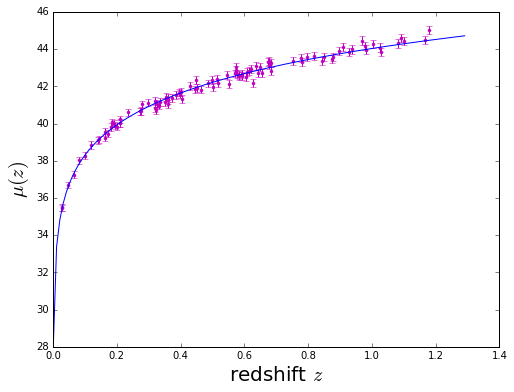

In [4]:
# To check this works we generate some theory curve to match the data
cosmoparams_orig = [70., 0.3, 0.7, -0.9, 0.2]
mulcdm = gen_ia(cosmoparams_orig, redshift, plot)
pl.figure(figsize=(8,6))
pl.xlabel(r'redshift $z$', fontsize=20)
pl.ylabel(r'$\mu(z)$', fontsize=20)
pl.errorbar(sndata[0], sndata[1],sndata[2],marker='.', color='m', linestyle='None')
pl.plot(redshift, mulcdm)

### Now that we have called our distance modulus once and know how to do it, we can also compute it over a range of parameters.

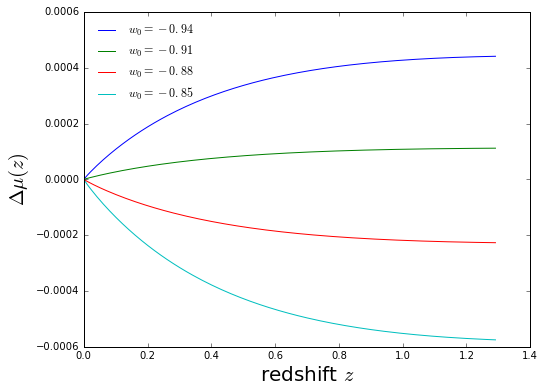

In [5]:
wvals = np.arange(-0.94,-0.84,0.03)
pl.figure(figsize=(8,6))
cosmoparams=list(cosmoparams_orig)

# changing oonly the wvalue for now

for wval in wvals:
    cosmoparams[3] = wval
    mu = gen_ia(cosmoparams, redshift, plot=False)
    pl.plot(redshift, (mu-mulcdm)/mulcdm, label=r'$w_0=%s$'%wval)

pl.xlabel(r'redshift $z$', fontsize=20)
pl.ylabel(r'$\Delta \mu(z)$', fontsize=20)    
leg = pl.legend(loc='best')
leg.draw_frame(False)
    
    

## Now let's make a fake likelihood for the SN data. Of course this is over-simplified, we know that the errors are correlated, and that we need to account for the LC parameters too.

In [6]:
## Fake likelihood for LSST SN data

def sn_likelihood(cosmoparams, loaddata=True):
      
    if loaddata: 
        # if it is the first time, load the data
        data = np.loadtxt('workshop_datav3.txt', unpack=True)
        
    redshift = data[0] # we are just assuming that the distance modulus is at the same redshift as the binned value 
    modelmu = gen_ia(cosmoparams, redshift, plot=False)
    num_sn=len(data[0])
    loglike = (data[1]-modelmu)**2/(2.*data[2]**2)
    loglike=-np.sum(loglike,axis=0)
    return loglike, num_sn


## Define a prior while you are sampling so you don't go to weird places (ie negative Omega_m)
def snprior(cosmoparams):
    p = -np.ones(len(cosmoparams))
    
    # Gaussian priors
    
    
    #p[0] = -((cosmoparams[0])-70.)**2/(2.*5)**2
    p[1] = -((cosmoparams[1])-0.3)**2/(2.*0.02)**2
    #p[2] = -((cosmoparams[2])-0.7)**2/(2.*0.02)**2
    p[3] = -((cosmoparams[2])+0.9)**2/(2.*0.7)**2
    
    # hard cuts
    if ((cosmoparams[0]< 50) or (cosmoparams[0]> 100)):
        p[0] = -3000
    if (cosmoparams[1] < 0):
        p[1] = -3000
    if (cosmoparams[2]< 0):
        p[2] =-3000
    if (cosmoparams[3]< -2):
        p[3] = -3000
    if ((cosmoparams[4]< -2) or (cosmoparams[4]> 2)):
        p[4] = -3000
        

    pp = sum(p)
    return pp

The first thing we notice is that we shouldn't just be taking the model spectrum at that bin, but we should be binning the theory.
<font color='red'>EXCERCISE if interested: </font>  Write a module to bin the theory over the same redshift range as the binned data.

In [7]:
# Your code here

Your discussion here.

In [8]:
# Let's call the module for the spectrum we have above.
model = list(cosmoparams_orig)
loglike, num_sn = sn_likelihood(model)
print loglike, num_sn, loglike/num_sn

-46.1869757591 100 -0.461869757591


### We want to take a step in this 5-D parameter space specified by the step vector. 

In [9]:
# Using this code above, we can take a gaussian step specified by the step vector below
stepvec = np.array([0.0,0.0001, 0.02, 0.005, 0.001])
nsteps = 2
loglike = np.zeros(nsteps)
for i in range(nsteps):
    if i==0:
        # First step
        step = list(cosmoparams_orig)
    else:
        # Take a Gaussian step from the previous position
        step = step+np.random.randn(len(cosmoparams))*stepvec
    
    
    model=step
    loglike[i], num_sn = sn_likelihood(model)
print 'loglike vector =', 2*loglike

loglike vector = [ -92.37395152 -296.27554319]


## MCMC
We are now ready to do the MCMC. We'll define the simplest/ugliest version of the Metropolis Hastings algorithm:

In [10]:
def mcmc_mh(ratln):
    accept=False
    r1 = np.random.rand()
    # If the step is definitely better, we want to accept it.
    # If it isn't necessarily better, we want to throw a random number and step if we exceed it
    if np.exp(ratln) > r1:
        accept=True
    return accept

In [11]:
# Using this code above, we can take a gaussian step specified by the step vector below
if (root=='large_error'):
    stepvec = np.array([0.0,0.03, 0.0, 0.005, 0.0])
else:
    stepvec = np.array([0.0,0.005, 0.0, 0.001, 0.0])
    
paramsvec=np.array(cosmoparams_orig)
steps = 10000
loglike = np.zeros(steps)
prior = np.zeros(steps)
post = np.zeros(steps)
stepskeep = np.zeros((steps,len(paramsvec)+1))
accept_count=0
for i in range(steps):
    
    if i==0:
        step = np.array(paramsvec)
        accept=True
        model=list(step)
        loglike[i], num_sn = sn_likelihood(model)
        prior[i] = snprior(model)
        post[i] = loglike[i]+prior[i]
        stepskeep[i,0:len(paramsvec)] = np.array(step)
        stepskeep[i,len(paramsvec)]= loglike[i]
    else:
        step = stepskeep[i-1,0:len(paramsvec)]+np.random.randn(len(paramsvec))*stepvec
        model=list(step)
        prior[i] = snprior(model)
        if (prior[i]>-3000):
            loglike[i], num_sn = sn_likelihood(model)
            post[i] = loglike[i]+prior[i]
            rat = post[i]-post[i-1]
            accept = mcmc_mh(rat)
        else:
            accept=False
                
        
        if accept:   
            stepskeep[i,0:len(paramsvec)] = np.array(step)
            stepskeep[i,len(paramsvec)] = loglike[i]
            accept_count+=1
        else:
            stepskeep[i,0:len(paramsvec)] = stepskeep[i-1,0:len(paramsvec)]
            loglike[i] = loglike[i-1]
            stepskeep[i,len(paramsvec)] = loglike[i]
        if (steps%i ==0):
            print 'acceptance ratio = ', accept_count/float(i), 'steps taken = ', i
    
            
np.savetxt('chain_'+root+'.txt', stepskeep, delimiter=' ', fmt='%.3e')
print 'we are done'

acceptance ratio =  0.0 steps taken =  1
acceptance ratio =  0.5 steps taken =  2
acceptance ratio =  0.5 steps taken =  4
acceptance ratio =  0.6 steps taken =  5
acceptance ratio =  0.5 steps taken =  8
acceptance ratio =  0.6 steps taken =  10
acceptance ratio =  0.625 steps taken =  16
acceptance ratio =  0.6 steps taken =  20
acceptance ratio =  0.6 steps taken =  25
acceptance ratio =  0.575 steps taken =  40


/Users/reneehlozek/Code/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp


acceptance ratio =  0.56 steps taken =  50
acceptance ratio =  0.5375 steps taken =  80
acceptance ratio =  0.53 steps taken =  100
acceptance ratio =  0.536 steps taken =  125
acceptance ratio =  0.52 steps taken =  200
acceptance ratio =  0.512 steps taken =  250
acceptance ratio =  0.52 steps taken =  400
acceptance ratio =  0.508 steps taken =  500
acceptance ratio =  0.4944 steps taken =  625
acceptance ratio =  0.495 steps taken =  1000
acceptance ratio =  0.4888 steps taken =  1250
acceptance ratio =  0.495 steps taken =  2000
acceptance ratio =  0.492 steps taken =  2500
acceptance ratio =  0.4926 steps taken =  5000
we are done


### We don't actually want to read in the data every time. 
<font color='red'>EXCERCISE if interested: </font> Change the likelihood function to only read in the data the first time it is called.

In [12]:
## Your code here

## Now that we've run the chain, let's analyse it to see what the constraints look like

mean for om: 0.30914446 0.0719732716868
mean for w0: -0.9160859 0.0939437934256


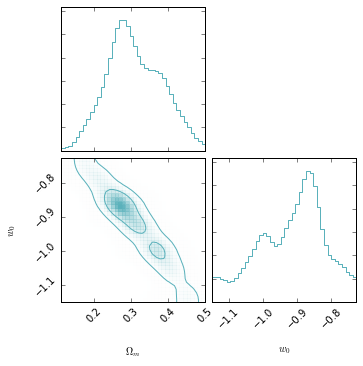

In [22]:
# Read in the chain
import corner

chain = np.loadtxt('chain_'+root+'.txt', unpack=True)
burn = np.int(0.5*len(chain[0,:])) # burn off some initial part of the chain
pl.figure(2)
sigma = 1.0

chain_colour = '#5AB1BB'
binnum=40
newchain = np.zeros((len(chain[0,burn:]),2))
newchain[:,0] = chain[1,burn:]
newchain[:,1] = chain[3,burn:]

fig1 = corner.corner(newchain,
        color=chain_colour,smooth1d=2,smooth=2,plot_datapoints=False,levels=(1-np.exp(-0.5),1-np.exp(-2.)),
        density=True,bins=binnum, labels=[r'$\Omega_m$', r'$w_0$'])


fig1.figsize=[20,20]
#rcParams["figure.figsize"] = [10,10]
pl.savefig(root+'.png')
print 'mean for om:', np.mean(chain[1,burn:]), np.std(chain[1,burn:])
print 'mean for w0:', np.mean(chain[3,burn:]), np.std(chain[3,burn:])

## Fisher matrix

In this case we want to compute the Fisher derivatives for a given parameter of interest, and include the errors that are simulated and then forecast the constraints on the parameters around an assumed model.

<img src="fisher.png">

In [14]:
# We start by having a model that will change the cosmology within the Fisher matrix
def assign_cosmo(cosmo,model=[70, 0.3,0.7, -0.9, 0.2]):
    import astropy as ap
    from astropy.cosmology import Planck15, Flatw0waCDM
    ob0=0.022
    om0=model[1]
    ode0 =model[2]
    newcosmo = cosmo.clone(name='temp cosmo', H0=model[0], Ob0=ob0, Om0=om0, Ode0=ode0, w0=model[3], wa=model[4])
    #print newcosmo.Ok0
    return newcosmo

In [15]:
# Define code that returns the mu and the Fisher matrix
def fish_deriv_m(redshift, model, step):
    "takes the model vector - for now [h0,om,ok,w0,wa], step vector (0 if not step) \
    data vector and gives back the derivs and the base function value at those \
    redshifts"
    from astropy.cosmology import w0waCDM
    from astropy import constants as const
    import pylab as pl
    Ob0=0.022
    Om0=model[1]
    Ode0 =model[2]
    cosmo = w0waCDM(model[0], Ob0, Om0, Ode0, model[3],model[4])

    cosmo=assign_cosmo(cosmo, model)
    #print cosmo.Ok0
    m = []
    m_deriv = []
    c = const.c.to('km/s')
    base_theory = cosmo.distmod(redshift)
    m = base_theory.value 
    step_inds = np.where(step)[0] # look for non-zero step indices                                                                                              
    deriv = np.zeros((len(base_theory), len(model)))

    if (step_inds.size==0):
        print 'No steps taken, abort'
        exit

    else:
        print '\n'
        print 'Computing Fisher derivatives...'

        for i, stepp in enumerate(step_inds):
            print 'we are stepping in :', model[stepp], ' with step size', step[stepp]
            cosmo = assign_cosmo(cosmo, model)

            theory = np.zeros((len(base_theory),2))
            for count,j  in enumerate([-1,1]):

                tempmodel = list(model)
                tempmodel[stepp] = model[stepp] + j*step[stepp]
                #print tempmodel
                c = const.c.to('km/s')
                cosmo = assign_cosmo(cosmo, tempmodel)
                tmp = cosmo.distmod(redshift)
                theory[:,count] = tmp.value 

            deriv[:,stepp] = (theory[:,1] - theory[:,0])/(2.*step[stepp])



    m_deriv = deriv
    return m, m_deriv



Computing Fisher derivatives...
we are stepping in : 0.3  with step size 0.001
we are stepping in : -0.9  with step size 0.1


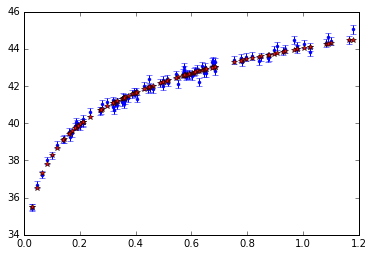

In [16]:
stepvec = np.array([0, 0.001, 0.00, 0.1, 0.0])
model = [70., 0.3, 0.7, -0.9, 0.2]
names = ['hubble', 'omega_m', 'omega_de', 'w0', 'wa']
step_inds = np.where(stepvec)[0] 
fishermu, deriv = fish_deriv_m(sndata[0], model, stepvec)
pl.errorbar(sndata[0],sndata[1], sndata[2], marker='.', linestyle='None')
pl.plot(sndata[0], fishermu, marker='*', color='r', linestyle='None')

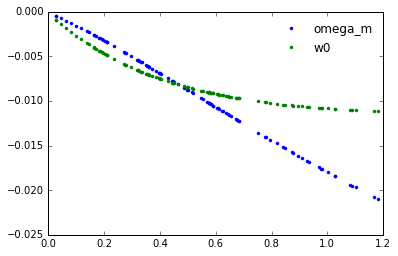

In [17]:
# lets plot the Fisher derivaties for interest
for i in step_inds:
    pl.plot(sndata[0], deriv[:,i]/fishermu, label=names[i],marker='.', linestyle='None')

leg = pl.legend(loc='best', numpoints=1)
leg.draw_frame(False)

In [18]:
# We are setting up the covariance data for the Fishermatrix

cov = np.diag(sndata[2]**2)
inv_cov = np.diag(1./sndata[2]**2.)

In [19]:
# Initialising the Fisher Matrix
FM = np.zeros((len(step_inds), len(step_inds), len(sndata[2]) ))

In [20]:
# Compute the Fisher matrix
for i in range(len(step_inds)):
    # loop over variables
    for j in range(len(step_inds)):
        # loop over variables
        for k in range(len(sndata[0])):
            # loop over redshifts
            invcov = inv_cov[k,k]
            FM[i,j,k] = np.dot(np.dot(deriv[k,step_inds[i]], invcov), deriv[k,step_inds[j]])

# sum over the redshift direction
fishmat = np.sum(FM,axis=2)


# Compute the prior matrix
prior_vec = np.array([0.1, 0.02, 0.0006, 0.2, 0.2])
priormat = np.diag(1./prior_vec[step_inds]**2.)

final_FM = fishmat + priormat
covmat = np.linalg.inv(final_FM)
sigma = np.sqrt(covmat.diagonal())
print 'Fisher matrix results'
print 'error for om:', sigma[0]
print 'error for w0:', sigma[1]
print 'MCMC results'
print 'error for om:',  np.std(chain[1,:])
print 'error for w0:',  np.std(chain[3,:])

Fisher matrix results
error for om: 0.0197479573476
error for w0: 0.062374133148
MCMC results
error for om: 0.0639747449326
error for w0: 0.0808378067447


### In general the Cramer-Rao bound states that the Fisher matrix will always be smaller than the MCMC bound. The smaller the errorbars - the more Gaussian the contours and the more the FM contours agree with the MCMC ones!

In [21]:
## Print differece
print  np.std(chain[1,:])/sigma[0]
print np.std(chain[3,:])/sigma[1]

3.2395626447
1.29601491299
